In [70]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (Mac의 경우)
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

## 1. 일주일 예측

📊 XGBoost 예측 성능 (2025-04-03 ~ 2025-04-09)
RMSE: 467.68
MAE : 373.41
R²  : -1.0393


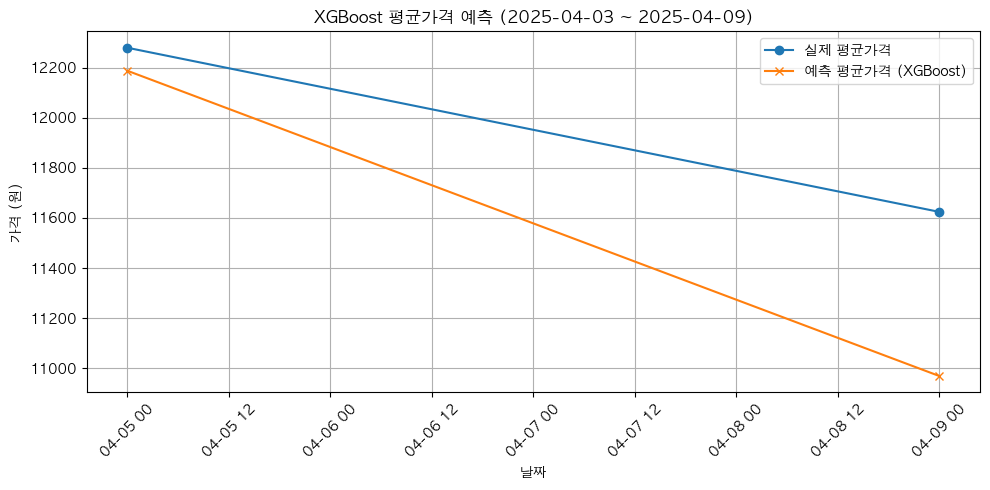

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 2. 피처 설정
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]
target_col = "log_평균가격"

# 3. 학습/예측 구간 설정
target_start = pd.to_datetime("2025-04-03")
target_end = pd.to_datetime("2025-04-09")

# 결측 제거
df = df.dropna(subset=[target_col] + feature_cols)

# 데이터 분할
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 4. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. XGBoost 모델 학습
model = xgb.XGBRegressor(
    n_estimators=50,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=4
)
model.fit(X_train_scaled, y_train)

# 6. 예측 및 복원
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test.values)

# 7. 성능 평가
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("📊 XGBoost 예측 성능 (2025-04-03 ~ 2025-04-09)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

# 8. 시각화
test_df = test_df.copy()
test_df["예측값"] = y_pred
test_df["실제값"] = y_true

plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], test_df["실제값"], label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], test_df["예측값"], label="예측 평균가격 (XGBoost)", marker='x')
plt.title("XGBoost 평균가격 예측 (2025-04-03 ~ 2025-04-09)")
plt.xlabel("날짜")
plt.ylabel("가격 (원)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2. 한달 예측

📊 예측 성능 (2025-03-10 ~ 2025-04-09)
RMSE: 3956.42
MAE : 3234.06
R2  : -6.2482


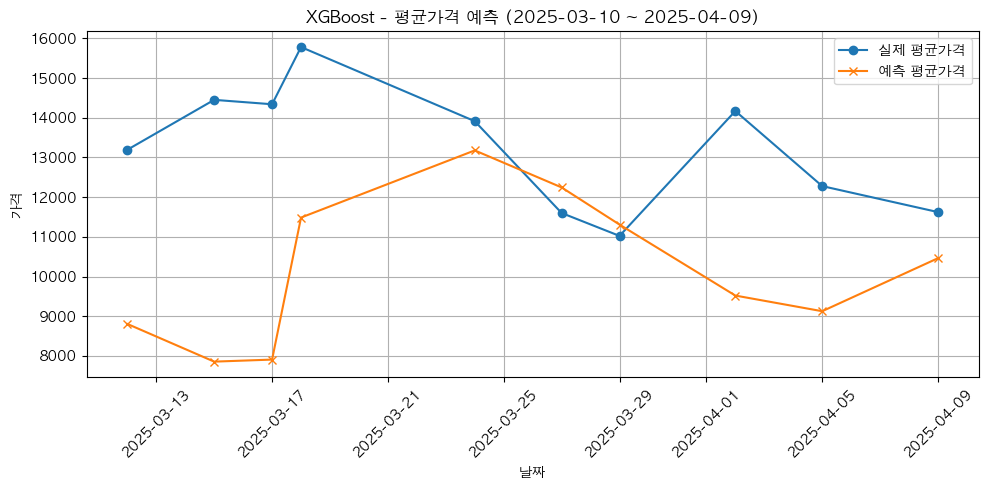

In [36]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 데이터 불러오기 및 정렬
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 피처 및 타겟 정의
feature_cols = [
    "humidity", "insolation", "precipitation", "temperature", "wind",
    "총반입량", "전일대비_반입량차이", "전일대비_반입량변화율(%)",
    "공휴일여부", "일요일여부"
]
target_col = "평균가격"

# 한 달 기준 테스트셋 정의
target_start = pd.to_datetime("2025-03-10")
target_end = pd.to_datetime("2025-04-09")

# 결측 제거 및 분할
df = df.dropna(subset=[target_col])
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)].dropna(subset=feature_cols)
train_df = df[df["DATE"] < target_start].dropna(subset=feature_cols)

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 모델 학습
model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.16, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가 지표 출력
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 예측 성능 (2025-03-10 ~ 2025-04-09)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], y_test.values, label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], y_pred, label="예측 평균가격", marker='x')
plt.title("XGBoost - 평균가격 예측 (2025-03-10 ~ 2025-04-09)")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


📊 XGBoost (log+lag) 예측 성능
RMSE: 576.26
MAE : 492.62
R2  : 0.8616


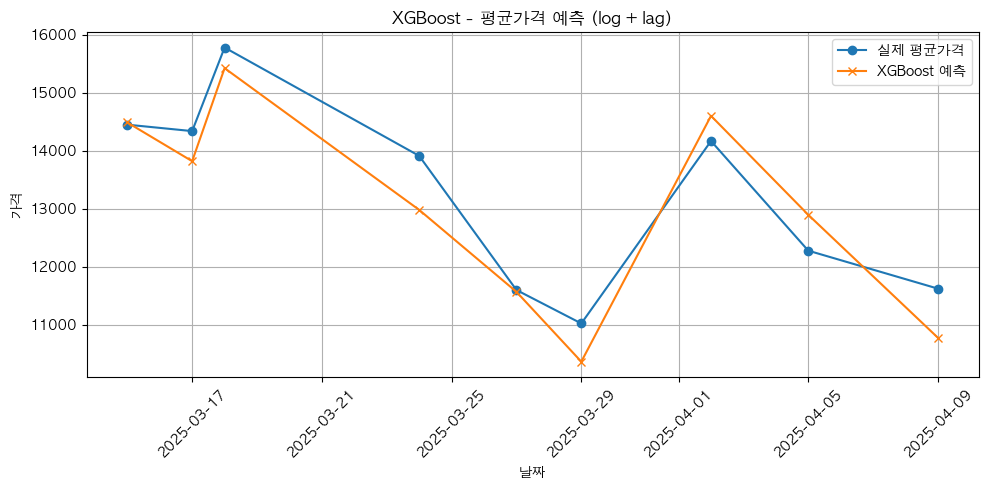

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 사용 피처
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]

# 학습/테스트셋 분할
target_col = "log_평균가격"
target_start = pd.to_datetime("2025-03-10")
target_end = pd.to_datetime("2025-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 2. 스케일링 (선택사항 – XGBoost는 필요 없지만 안정화에 도움될 수 있음)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. XGBoost 모델 학습
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42 
)
model.fit(X_train_scaled, y_train)

# 4. 예측 및 복원
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # log → 원 단위로 복원
y_true = np.expm1(y_test.values)

# 5. 평가 지표
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("📊 XGBoost (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

# 6. 시각화
plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], y_true, label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], y_pred, label="XGBoost 예측", marker='x')
plt.title("XGBoost - 평균가격 예측 (log + lag)")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2. 28일 예측

📊 XGBoost (log+lag) 예측 성능
RMSE: 657.41
MAE : 535.19
R2  : 0.3438


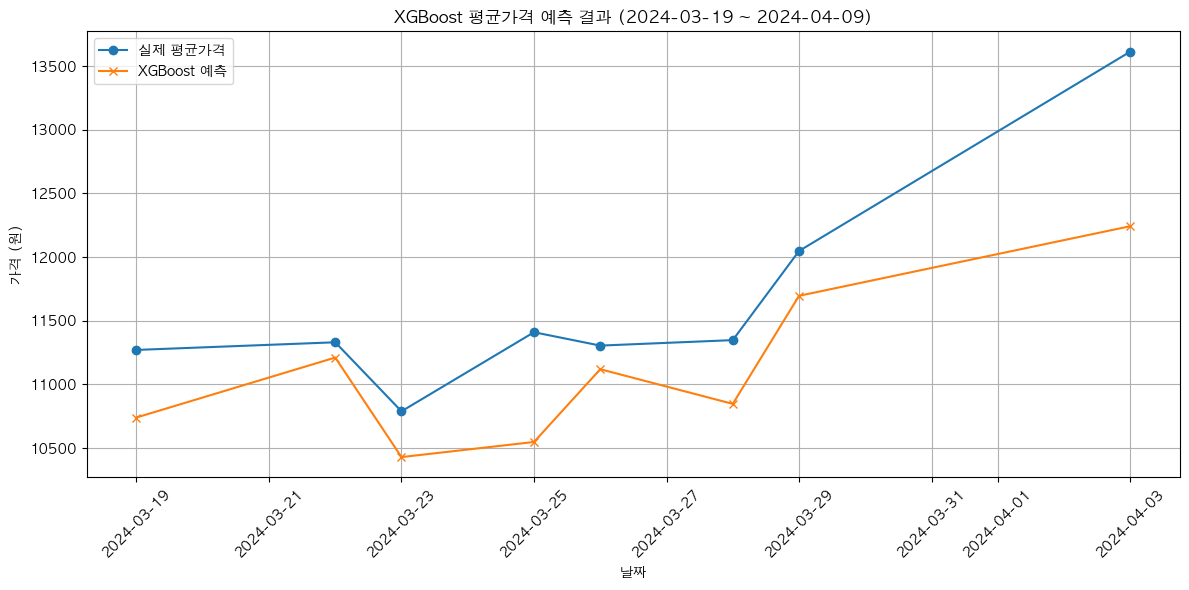

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 불필요한 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 사용 피처
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]

# 학습/테스트셋 분할
target_col = "log_평균가격"
target_start = pd.to_datetime("2024-03-19")
target_end = pd.to_datetime("2024-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 모델 학습
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 예측 및 복원
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test.values)

# 평가 지표 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 결과 리턴
test_df = test_df.copy()
test_df["예측값"] = y_pred
test_df["실제값"] = y_true



print("📊 XGBoost (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

import matplotlib.pyplot as plt

# 시각화를 위한 날짜, 실제값, 예측값 준비
plt.figure(figsize=(12, 6))
plt.plot(test_df["DATE"], test_df["실제값"], label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], test_df["예측값"], label="XGBoost 예측", marker='x')

# 제목, 축 라벨, 기타 설정
plt.title("XGBoost 평균가격 예측 결과 (2024-03-19 ~ 2024-04-09)")
plt.xlabel("날짜")
plt.ylabel("가격 (원)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 3. 2달 예측

📊 XGBoost (log+lag) 예측 성능
RMSE: 584.48
MAE : 484.30
R2  : 0.9003


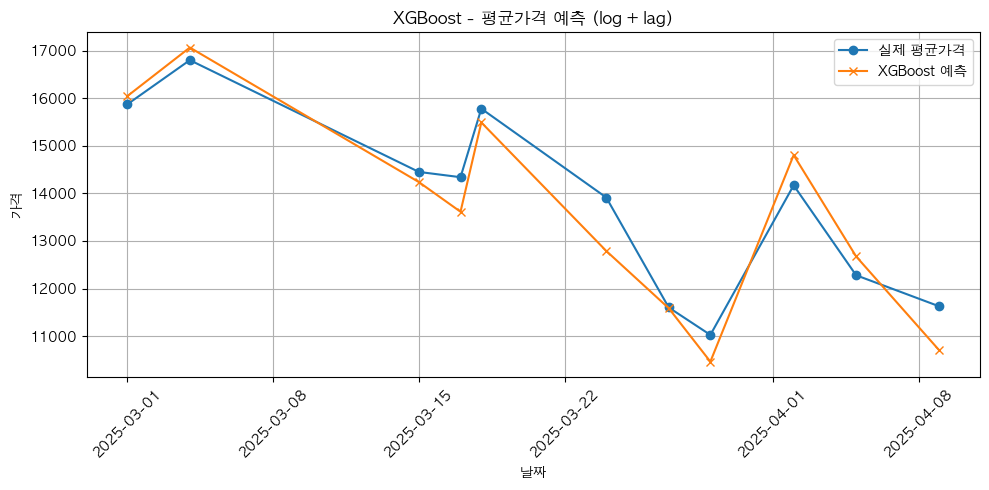

In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 사용 피처
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]

# 학습/테스트셋 분할
target_col = "log_평균가격"
target_start = pd.to_datetime("2025-02-09")
target_end = pd.to_datetime("2025-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 2. 스케일링 (선택사항 – XGBoost는 필요 없지만 안정화에 도움될 수 있음)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. XGBoost 모델 학습
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42 
)
model.fit(X_train_scaled, y_train)

# 4. 예측 및 복원
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # log → 원 단위로 복원
y_true = np.expm1(y_test.values)

# 5. 평가 지표
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("📊 XGBoost (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

# 6. 시각화
plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], y_true, label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], y_pred, label="XGBoost 예측", marker='x')
plt.title("XGBoost - 평균가격 예측 (log + lag)")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


📊 XGBoost (log+lag) 예측 성능
RMSE: 529.99
MAE : 353.55
R2  : 0.8748


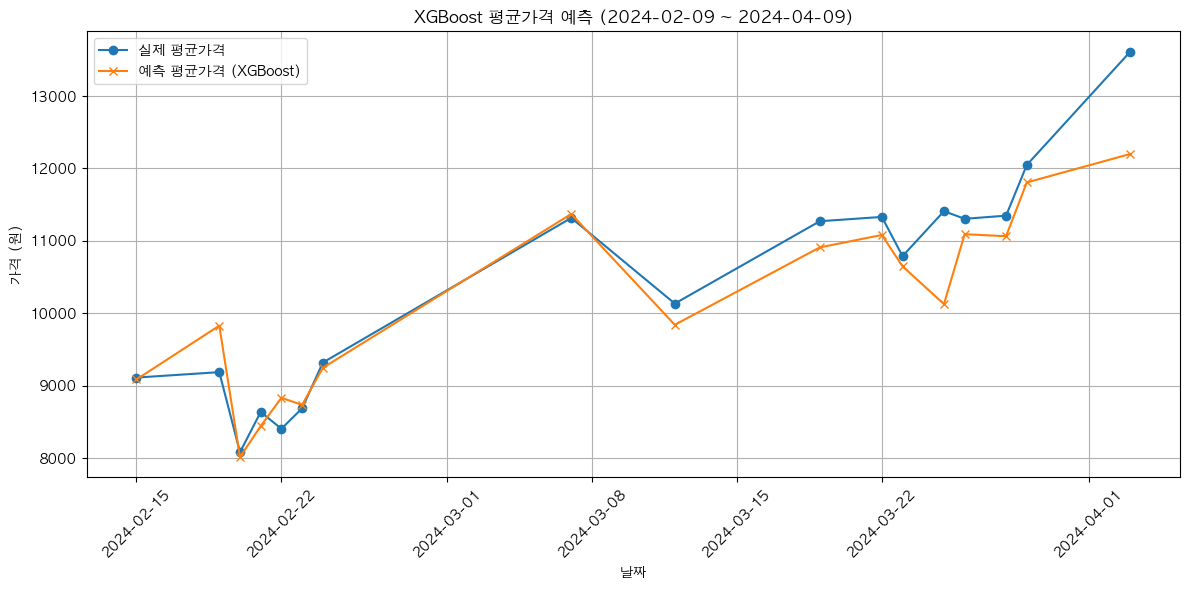

In [65]:
# 예측 대상 날짜 설정
target_start = pd.to_datetime("2024-02-09")
target_end = pd.to_datetime("2024-04-09")

# 누락된 전처리 및 준비 절차 반복
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]
target_col = "log_평균가격"
df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 스케일링 및 모델 정의
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBRegressor(
    n_estimators=50,      # 빠른 학습을 위해 조정
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=4
)
model.fit(X_train_scaled, y_train)

# 예측 및 결과 정리
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test.values)

test_df = test_df.copy()
test_df["예측값"] = y_pred
test_df["실제값"] = y_true

# 평가 지표
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("📊 XGBoost (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 선 그래프: 실제값과 예측값
plt.plot(test_df["DATE"], test_df["실제값"], label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], test_df["예측값"], label="예측 평균가격 (XGBoost)", marker='x')

# 그래프 꾸미기
plt.title("XGBoost 평균가격 예측 (2024-02-09 ~ 2024-04-09)")
plt.xlabel("날짜")
plt.ylabel("가격 (원)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# 시각화 출력
plt.show()


In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

# 1. 데이터 로딩 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 불필요한 열 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag + log 피처 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 피처 설정
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]
target_col = "log_평균가격"

# 결측치 제거
df = df.dropna(subset=[target_col] + feature_cols)

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])
y = df[target_col].values

# 3. TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled), 1):
    X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train_cv, y_train_cv)

    y_pred_log = model.predict(X_test_cv)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_cv)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"[Fold {fold}] RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

# 4. 평균 결과 출력
print("\n📊 TimeSeriesSplit 기반 평균 성능")
print(f"평균 RMSE: {np.mean(rmse_list):.2f}")
print(f"평균 MAE : {np.mean(mae_list):.2f}")
print(f"평균 R²  : {np.mean(r2_list):.4f}")


[Fold 1] RMSE: 1231.87, MAE: 958.20, R²: 0.6744
[Fold 2] RMSE: 1022.42, MAE: 633.67, R²: 0.8968
[Fold 3] RMSE: 1770.88, MAE: 841.38, R²: 0.9034
[Fold 4] RMSE: 732.86, MAE: 494.28, R²: 0.9563
[Fold 5] RMSE: 2123.54, MAE: 1086.81, R²: 0.8606

📊 TimeSeriesSplit 기반 평균 성능
평균 RMSE: 1376.31
평균 MAE : 802.87
평균 R²  : 0.8583


/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_97172/2709947758.py:27: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  plt.tight_layout()
/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_97172/2709947758.py:27: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()


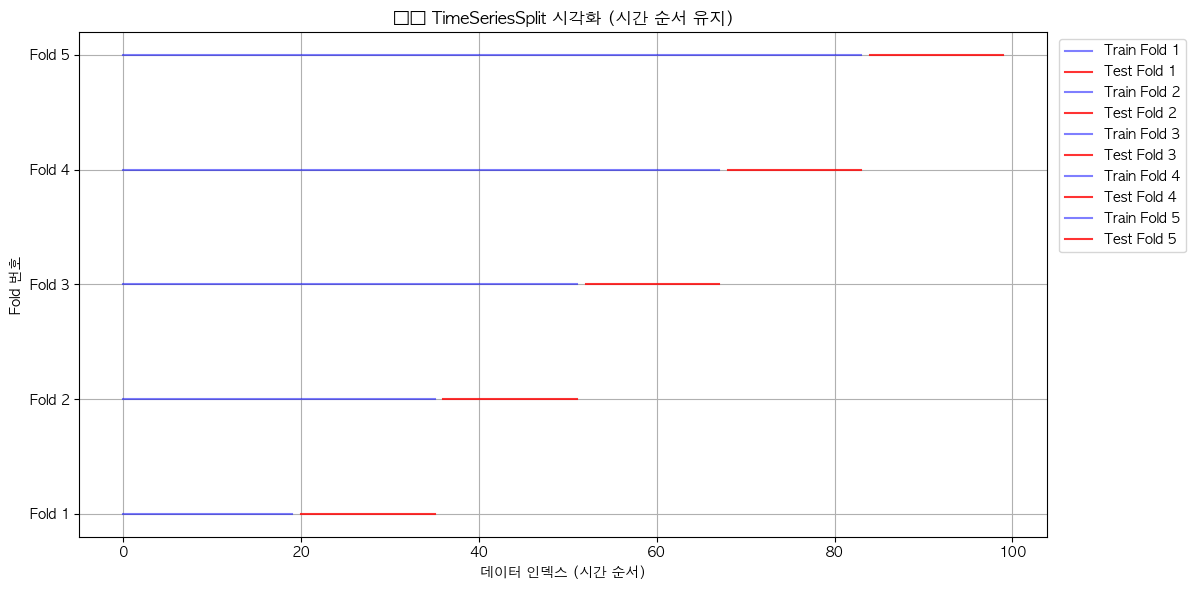

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# 예시용 더미 날짜 데이터 생성
date_range = pd.date_range(start="2024-12-01", periods=100, freq="D")
data = pd.DataFrame({"DATE": date_range, "index": np.arange(100)})

# TimeSeriesSplit 시각화
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(data))

# 시각화
plt.figure(figsize=(12, 6))

for i, (train_idx, test_idx) in enumerate(splits):
    plt.plot(train_idx, [i + 1] * len(train_idx), label=f"Train Fold {i+1}", color="blue", alpha=0.5)
    plt.plot(test_idx, [i + 1] * len(test_idx), label=f"Test Fold {i+1}", color="red", alpha=0.8)

plt.yticks(range(1, 6), [f"Fold {i}" for i in range(1, 6)])
plt.xlabel("데이터 인덱스 (시간 순서)")
plt.ylabel("Fold 번호")
plt.title("⏱️ TimeSeriesSplit 시각화 (시간 순서 유지)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()
